In [ ]:
"""
Emma Hegermiller
Task:
Build a predictive model leveraging the historical data, additional data insights is a plus.
Model should forecast vin price based on the vehicle attributes provided above (i.e. make, model, make year, mileage, trim..)

Dataset information
index_pandas,
vin,
days_on_market,
listing_date_begin,
listing_date_end,
year,
make,
model,
trim,
body_style,
transmission,
mileage,
accident_count,
fuel_economy_city,
fuel_economy_highway,
exterior_color,
msrp,
is_cpo,
seller_city,
seller_state,
seller_type,
seller_is_franchise_dealer,
seller_is_online_only,
seller_ships_nationwide,
list_price, 
shift_buyer_region - not a velichle attribute

Steps:

Exploratory data analysis
    Count per categorical
    Price distribution overall
    Price distribution per categorical
Preprocessing
    drop rows with vin na
    change types of categories
Split into train/test
    based on date
    check vin overlap
Check collinearity
Feature engineering
    imputation
        drop values greater than 70% na
        group by vin
    One hot encoding
Model: Ridge Regression,Light GBM, CV Elastic net

Model performance: Root Mean Squared Logarithmic Error(RMSLE)

Questions:
Prediction timeline: prediction at listing or days after listing?
Same vins will have different vehicle attributes


https://towardsdatascience.com/mercari-price-suggestion-97ff15840dbd
https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114
"""

In [4]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import statsmodels.api as sm
from datetime import timedelta

In [116]:
import_directory = 'C:\\Users\\emmah\\Google Drive\\Job Applications\\TechnicalAssessment\\Shift\\data'

df_import =pd.read_csv(import_directory + '\\sample.csv')

C:\Users\emmah\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
df_import.head()

,index_pandas,vin,days_on_market,listing_date_begin,listing_date_end,year,make,model,trim,body_style,...,msrp,is_cpo,seller_city,seller_state,seller_type,seller_is_franchise_dealer,seller_is_online_only,seller_ships_nationwide,list_price,shift_buyer_region
0,0,19XFC1F30LE007261,12,2021-02-10,2021-02-22,2020,Honda,Civic,EX Sedan FWD,Sedan,...,NaN,NaN,"Davie, FL",FL,DEALER,True,NaN,NaN,20833.0,NaN
1,1,19XFC1F30LE007261,11,2021-02-10,2021-02-21,2020,Honda,Civic,EX Sedan FWD,Sedan,...,NaN,NaN,"Davie, FL",FL,DEALER,True,NaN,NaN,20833.0,NaN
2,2,19XFC1F30LE019698,14,2021-03-25,2021-04-08,2020,Honda,Civic,EX Sedan FWD,Sedan,...,23998.0,NaN,"Suffolk, VA",VA,DEALER,True,NaN,NaN,23998.0,NaN
3,3,19XFC1F30LE019698,13,2021-03-25,2021-04-07,2020,Honda,Civic,EX Sedan FWD,Sedan,...,23998.0,NaN,"Suffolk, VA",VA,DEALER,True,NaN,NaN,23998.0,NaN
4,4,19XFC1F31LE007317,10,2021-04-12,2021-04-22,2020,Honda,Civic,EX Sedan FWD,Sedan,...,NaN,True,"Albuquerque, NM",NM,DEALER,True,NaN,NaN,23333.0,NaN


In [130]:
df_import.columns

Index(['index_pandas', 'vin', 'days_on_market', 'listing_date_begin',
       'listing_date_end', 'year', 'make', 'model', 'trim', 'body_style',
       'transmission', 'mileage', 'accident_count', 'fuel_economy_city',
       'fuel_economy_highway', 'exterior_color', 'msrp', 'is_cpo',
       'seller_city', 'seller_state', 'seller_type',
       'seller_is_franchise_dealer', 'seller_is_online_only',
       'seller_ships_nationwide', 'list_price', 'shift_buyer_region',
       'mileage_normalized', 'accident_count_normalized',
       'fuel_economy_city_normalized', 'fuel_economy_highway_normalized',
       'msrp_normalized'],
      dtype='object')

In [79]:
df_import.dtypes

index_pandas                           int64
vin                                   object
days_on_market                         int64
listing_date_begin            datetime64[ns]
listing_date_end              datetime64[ns]
year                                   int64
make                                  object
model                                 object
trim                                  object
body_style                            object
transmission                          object
mileage                              float64
accident_count                       float64
fuel_economy_city                    float64
fuel_economy_highway                 float64
exterior_color                        object
msrp                                 float64
is_cpo                                object
seller_city                           object
seller_state                          object
seller_type                           object
seller_is_franchise_dealer            object
seller_is_

In [63]:
# Missingness
row_total = len(df_import)
df_import.isna().sum()/row_total

vin                           0.000000
listing_date_begin            0.000000
mileage                       0.023656
accident_count                0.017204
is_cpo                        0.000000
seller_city                   0.000000
seller_state                  0.000000
seller_type                   0.000000
seller_is_franchise_dealer    0.000000
seller_is_online_only         0.000000
seller_ships_nationwide       0.000000
list_price                    0.000000
year                          0.000000
make                          0.000000
model                         0.000000
trim                          0.020430
body_style                    0.000000
transmission                  0.025806
fuel_economy_city             0.073118
fuel_economy_highway          0.073118
exterior_color                0.026882
msrp                          0.574194
dtype: float64

In [7]:
# Looking at duplicate vin 
print("Count of unique vin {}".format(len(df_import.vin.unique())))
vehicle_attributes = ["vin", 
                      "listing_date_begin",
                      "year", 
                      "make", 
                      "model", 
                      "trim", 
                      "body_style", 
                      "transmission", 
                      "mileage", 
                      "accident_count", 
                      "fuel_economy_city", 
                      "fuel_economy_highway", 
                     "exterior_color"]
df_vehicle = df_import[vehicle_attributes].drop_duplicates()
ids = df_vehicle["vin"]
df_vehicle[ids.isin(ids[ids.duplicated()])].sort_values("vin")

Count of unique vin 294531


,vin,listing_date_begin,year,make,model,trim,body_style,transmission,mileage,accident_count,fuel_economy_city,fuel_economy_highway,exterior_color
57690,19XFC1F30LE004098,2020-07-12,2020,Honda,Civic,EX Sedan FWD,Sedan,Continuously Variable Transmission,1956.0,0.0,32.0,42.0,Gray
57688,19XFC1F30LE004098,2020-07-12,2020,Honda,Civic,EX Sedan FWD,Sedan,Continuously Variable Transmission,1969.0,0.0,32.0,42.0,Blue
57686,19XFC1F30LE004098,2020-07-12,2020,Honda,Civic,EX Sedan FWD,Sedan,Continuously Variable Transmission,2103.0,0.0,32.0,42.0,Blue
5311,19XFC1F30LE006966,2021-04-10,2020,Honda,Civic,EX Sedan FWD,Sedan,Continuously Variable Transmission,10396.0,0.0,32.0,42.0,Blue
5310,19XFC1F30LE006966,2021-04-09,2020,Honda,Civic,EX Sedan FWD,Sedan,Continuously Variable Transmission,10398.0,0.0,32.0,42.0,Aegean Blue Metallic
...,...,...,...,...,...,...,...,...,...,...,...,...,...
696650,NaN,2021-04-02,2020,Ford,F-250 Super Duty,Lariat Crew Cab 4WD,Pickup Truck,Automatic,16000.0,1.0,NaN,NaN,Grey
696651,NaN,2021-04-20,2020,Toyota,Corolla,SE FWD,Sedan,NaN,7550.0,0.0,NaN,NaN,Gray
696652,NaN,2021-04-19,2020,BMW,3 Series,330i xDrive Sedan AWD,Sedan,8-Speed Automatic Overdrive,41160.0,0.0,NaN,NaN,Jet Black
696653,NaN,2020-11-27,2020,Toyota,Corolla,LE FWD,Sedan,Automatic,5643.0,0.0,30.0,38.0,NaN


count    696656.000000
mean       2020.087838
std           0.283242
min        2020.000000
25%        2020.000000
50%        2020.000000
75%        2020.000000
max        2022.000000
Name: year, dtype: float64


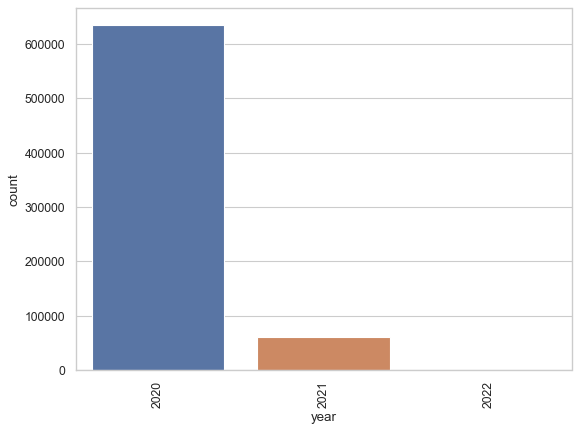

count     696656
unique         5
top       Toyota
freq      280958
Name: make, dtype: object


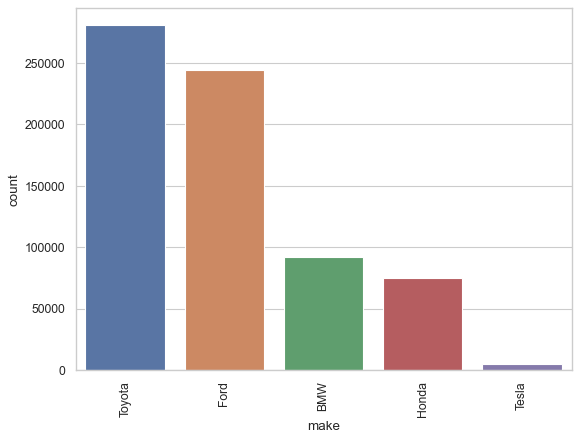

count      696656
unique        103
top       Corolla
freq        74831
Name: model, dtype: object


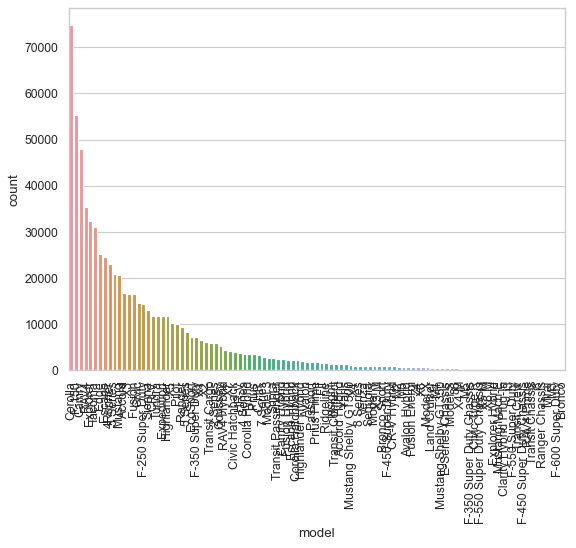

count     666563
unique       556
top       LE FWD
freq       94925
Name: trim, dtype: object


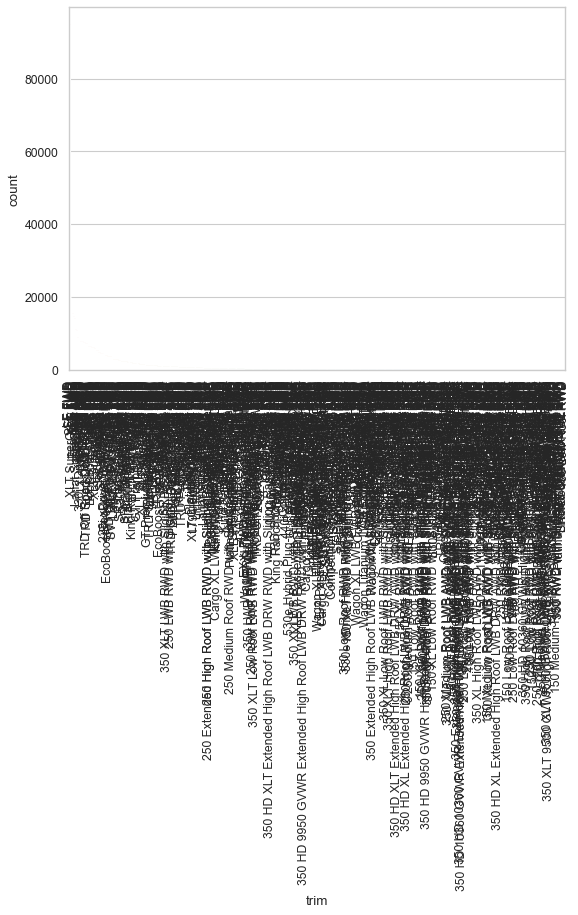

count              695489
unique                  9
top       SUV / Crossover
freq               262751
Name: body_style, dtype: object


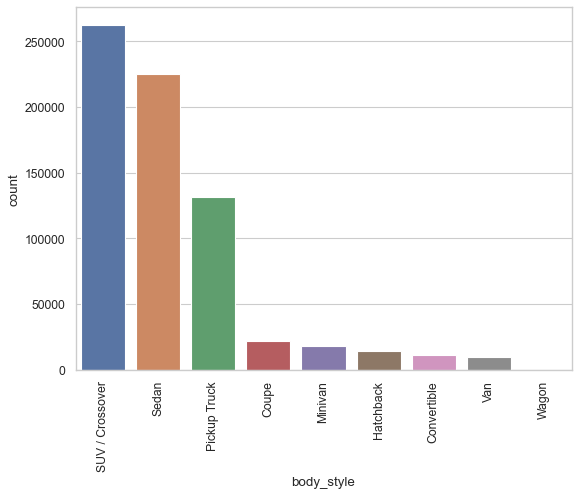

count        674696
unique           30
top       Automatic
freq         385105
Name: transmission, dtype: object


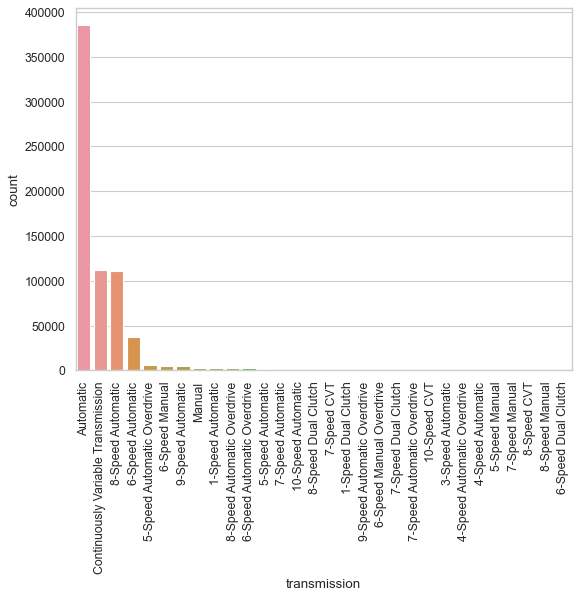

count     664760
unique      3462
top        White
freq       53647
Name: exterior_color, dtype: object


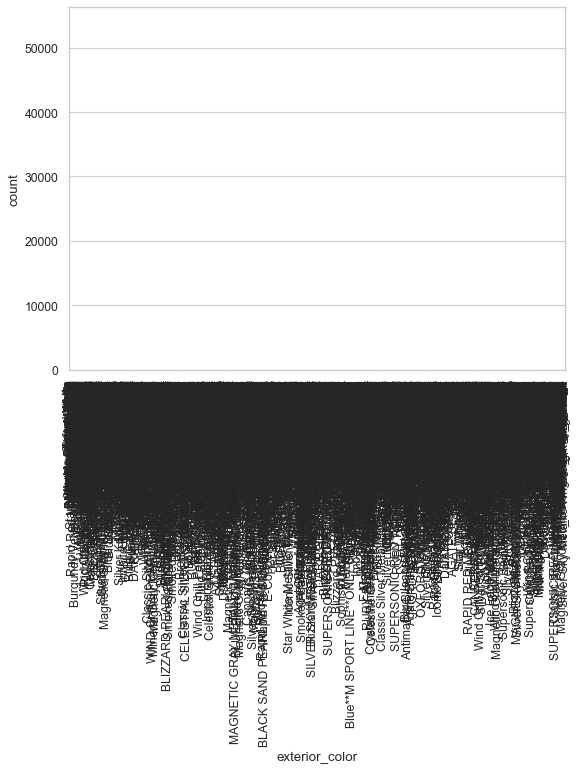

In [67]:
categorical_attributes = ["year", "make", "model", "trim", "body_style", "transmission", "exterior_color"]

for att in categorical_attributes:
    print(df_import[att].describe())
    plt.figure(figsize=(8, 6), dpi=80)
    ax = sns.countplot(x=att, data=df_import, order = df_import[att].value_counts().index)
    plt.xticks(rotation = 90)
    plt.show()

text_cols = ["trim", "transmission", "exterior_color"]
for col in text_cols:
    unique_cat = df_valid[col].unique()
    other_cat = []
    for cat in unique_cat:
        cat_count = len(df_valid[df_valid[col]==cat])
        if cat_count <395: # Categor count is less than 0.1%
            other_cat.append(cat)
        else:
            pass
    print(other_cat)
    print(len(other_cat))
    print(df_valid[col].describe())
    print(df_valid[col].isna().sum())

In [ ]:
# Mean price for brands, models?

sns.regplot(x=’brand_mean_price’, y=’price’, data=train,
            scatter_kws={‘alpha’:0.3}, line_kws={‘color’:’orange’})

In [ ]:
# Text feature extraction
# vectorizing name
vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=3, max_features=250000)

train_name_tfidf = vectorizer.fit_transform(train_df['preprocessed_name'].values)
cv_name_tfidf = vectorizer.transform(cv_df['preprocessed_name'].values)
test_name_tfidf = vectorizer.transform(test['preprocessed_name'].values)


# vectorixing item_description
vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=5, max_features=500000)

train_description_tfidf = vectorizer.fit_transform(train_df['preprocessed_description'].values)
cv_description_tfidf = vectorizer.transform(cv_df['preprocessed_description'].values)
test_description_tfidf = vectorizer.transform(test['preprocessed_description'].values)